In [42]:
import yfinance as yf

df = yf.download('TLT').reset_index()

[*********************100%***********************]  1 of 1 completed


In [44]:
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

df['trading_day_of_month'] = df.groupby(['Year', 'Month']).cumcount() + 1

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year,trading_day_of_month
0,2002-07-30,81.750000,81.900002,81.519997,81.519997,40.106686,6100,7,2002,1
1,2002-07-31,81.949997,82.800003,81.900002,82.529999,40.603596,29400,7,2002,2
2,2002-08-01,82.540001,83.019997,82.540001,83.000000,40.834820,25000,8,2002,1
3,2002-08-02,83.160004,84.099998,82.879997,83.849998,41.252987,52800,8,2002,2
4,2002-08-05,84.040001,84.440002,83.849998,84.220001,41.435017,61100,8,2002,3


In [45]:
max_trading_day = (
    df
    .groupby(['Year', 'Month'])
    .agg({'trading_day_of_month': 'max'}) 
    .rename(columns={'trading_day_of_month': 'max_trading_day_in_month'})
    .reset_index()
)

max_trading_day.head()

,Year,Month,max_trading_day_in_month
0,2002,7,2
1,2002,8,22
2,2002,9,20
3,2002,10,23
4,2002,11,20


In [46]:
df = pd.merge(
    df, 
    max_trading_day, 
    on=['Year', 'Month'], 
    how='left',
)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Year,trading_day_of_month,max_trading_day_in_month
0,2002-07-30,81.750000,81.900002,81.519997,81.519997,40.106686,6100,7,2002,1,2
1,2002-07-31,81.949997,82.800003,81.900002,82.529999,40.603596,29400,7,2002,2,2
2,2002-08-01,82.540001,83.019997,82.540001,83.000000,40.834820,25000,8,2002,1,22
3,2002-08-02,83.160004,84.099998,82.879997,83.849998,41.252987,52800,8,2002,2,22
4,2002-08-05,84.040001,84.440002,83.849998,84.220001,41.435017,61100,8,2002,3,22


In [47]:
import numpy as np

df['days_from_max_day'] = df['max_trading_day_in_month'] - df['trading_day_of_month']
df['signal'] = np.where((df['days_from_max_day'] < 7) & (df['days_from_max_day'] != 0), 1, 0)
df['pct_changes'] = df['Adj Close'].pct_change()
df['strat_percs'] = df['signal'].shift(1)*df['pct_changes']

df = df.dropna()

df['buy_and_hold_equity'] = np.cumprod(1+df['pct_changes'])
df['strat_equity'] = np.cumprod(1+df['strat_percs'])

<Axes: xlabel='Date'>

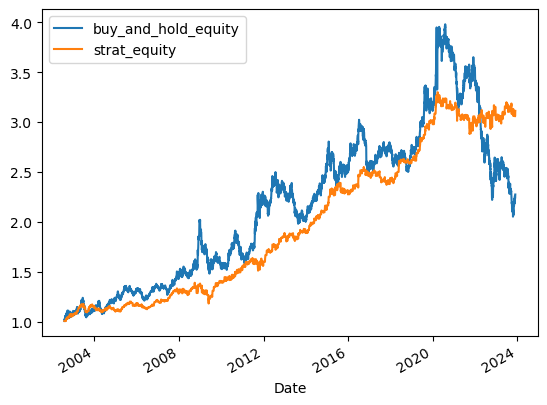

In [48]:
df.plot(x='Date', y=['buy_and_hold_equity', 'strat_equity'])

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

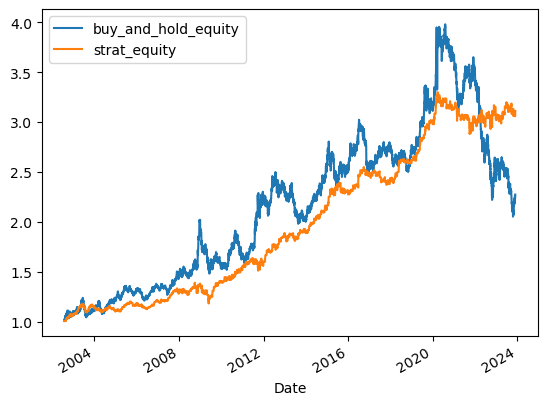

In [41]:
import numpy as np
import pandas as pd
import yfinance as yf

# Obtain the data from yahoo finance
df = yf.download('TLT').reset_index()

# Create date columns to find the trading day of the month
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# The trading day of the month is found over the year/month combination
df['trading_day_of_month'] = df.groupby(['Year', 'Month']).cumcount() + 1

# To find the max day, perform an aggregation and join back on to the table
max_trading_day = (
    df
    .groupby(['Year', 'Month'])
    .agg({'trading_day_of_month': 'max'}) 
    .rename(columns={'trading_day_of_month': 'max_trading_day_in_month'})
    .reset_index()
)

df = pd.merge(df, max_trading_day, on=['Year', 'Month'], how='left')

# Now we can determine how many trading days we have left in the month
df['days_from_max_day'] = df['max_trading_day_in_month'] - df['trading_day_of_month']

# The signal is we buy on the 7th last trading day, note that 0 days left = last day, so 6 = 7th last day
df['signal'] = np.where((df['days_from_max_day'] < 7) & (df['days_from_max_day'] != 0), 1, 0)

# Determine the strategy percentages from the signal, and the equity of both strat & buy and hold
df['pct_changes'] = df['Adj Close'].pct_change()
df['strat_percs'] = df['signal'].shift(1)*df['pct_changes']

df = df.dropna()

df['buy_and_hold_equity'] = np.cumprod(1+df['pct_changes'])
df['strat_equity'] = np.cumprod(1+df['strat_percs'])

# Plot the equity curves
df.plot(x='Date', y=['buy_and_hold_equity', 'strat_equity'])

In [69]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Line(x=df['Date'], y=df['buy_and_hold_equity'], name='Buy and Hold'))
fig.add_trace(go.Line(x=df['Date'], y=df['strat_equity'], name='Strategy'))

fig.update_layout(
    title='TLT End of Month Strategy',
    xaxis={'title': 'Date'},
    yaxis={'title': 'Multiple from Initial Investment'},
)

fig.show()

In [74]:
def get_max_drawdown(col):
    drawdown = col/col.cummax()-1
    return 100*drawdown.min()

def sharpe_ratio(returns):
    return np.sqrt(252)*returns.mean()/returns.std()

def calculate_cagr(col, n_years):
    cagr = (col.values[-1]/col.values[0])**(1/n_years)-1
    return 100*cagr

print('Maximum Drawdown Buy and Hold:', get_max_drawdown(df['buy_and_hold_equity']))
print('Maximum Drawdown Strategy:', get_max_drawdown(df['strat_equity']))

print('Sharpe Ratio Buy and Hold:', sharpe_ratio(df['pct_changes']))
print('Sharpe Ratio Strategy:', sharpe_ratio(df['strat_percs']))

n_years = (df['Date'].max()-df['Date'].min()).days/365.25
print('CAGR Buy and Hold:', calculate_cagr(df['buy_and_hold_equity'], n_years))
print('CAGR Strategy:', calculate_cagr(df['strat_equity'], n_years))

Maximum Drawdown Buy and Hold: -48.351127487520614
Maximum Drawdown Strategy: -14.900777977355196
Sharpe Ratio Buy and Hold: 0.33940117282207805
Sharpe Ratio Strategy: 0.7770707485008013
CAGR Buy and Hold: 3.8765880230725136
CAGR Strategy: 5.411409304979475
